##### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

## Synthetic data

In [4]:
# TODO add a final completely random rotation element (same across whole
# measurement sequence) to represent the fact that we don't know where
# gravity is pointing relative to the sensor


def generate_stationary_noise(length):
    """Generate random normally distributed accelerometer measurements
    representing the noise experienced by a stationary sensor."""
    return np.random.normal(0, 1, (length, 3))


#def generate_linear_data(length):
#    """Generate normally distributed random data representing linear
#    acceleration along a vector, like a dumbbell squat."""
#    # TODO this doesn't look right
#    movement_vector = (np.random.random(3) - 0.5) * 2
#    movement_vectors = np.tile(movement_vector, (length, 1))
#    random_scalars = np.random.normal(0, 1, length)
#    angular_v = movement_vectors * random_scalars[:, None]
#    return angular_v

def generate_linear_data(length):
    pass


def generate_circular_data(length, radius=1, angle=2 * np.pi):
    """Generate acceleration data representing 2D circular motion,
    like a dumbbell curl."""
    # TODO also add the rising edge of the exercise

    # Generate x and y coordinates of an arc segment (no z yet)
    angular_v = np.zeros((length, 3))
    angular_v[:, 0] = radius * np.cos(np.linspace(0, angle, length))
    angular_v[:, 1] = radius * np.sin(np.linspace(0, angle, length))

    # Do some rotations to simulate the motion of a dumbbell curl
    # Rotate 0.53pi radians about z counterclockwise
    theta_z = -0.53 * np.pi
    R_z = np.array(
        [
            [np.cos(theta_z), -np.sin(theta_z), 1],
            [np.sin(theta_z), np.cos(theta_z), 0],
            [0, 0, 1],
        ]
    )

    # Flip about y
    theta_y = -np.pi
    R_y = np.array(
        [
            [np.cos(theta_y), 0, np.sin(theta_y)],
            [0, 1, 0],
            [-np.sin(theta_y), 0, np.cos(theta_y)],
        ]
    )

    R = np.dot(R_z, R_y)
    angular_v = np.dot(angular_v, R)

    return angular_v

### Synthetic dumbbell curl

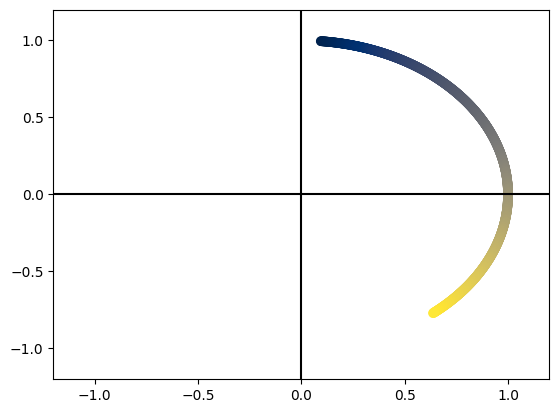

In [5]:
curl_down = generate_circular_data(1000, angle=0.75*np.pi)

# Four-quadrant XY plot
# Plot points in scatter wiht changing colour to indicate direction
plt.scatter(curl_down[:, 0], curl_down[:, 1], c=np.linspace(0, 1, len(curl_down)), cmap="cividis")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axvline(0, color="black")
plt.axhline(0, color="black")
plt.show()

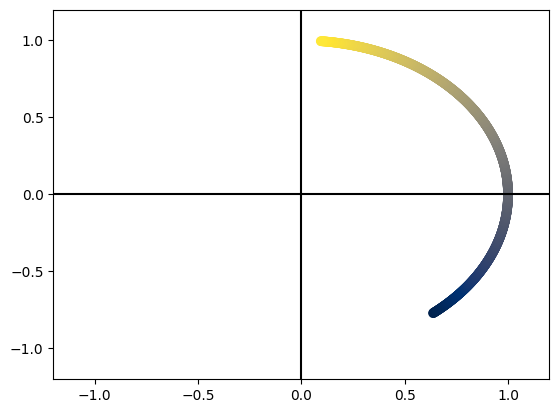

In [6]:
curl_up = curl_down[::-1, :]

# Four-quadrant XY plot
# Plot points in scatter wiht changing colour to indicate direction
plt.scatter(curl_up[:, 0], curl_up[:, 1], c=np.linspace(0, 1, len(curl_up)), cmap="cividis")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axvline(0, color="black")
plt.axhline(0, color="black")
plt.show()

/home/sam/.local/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


TypeError: 'NoneType' object is not subscriptable

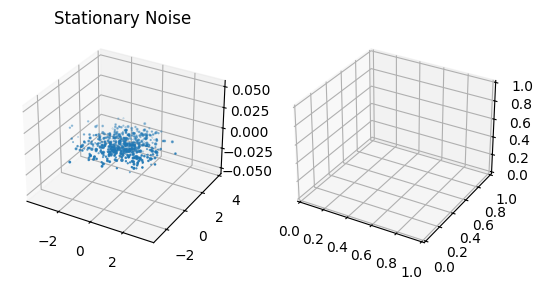

In [7]:
# Testing all three generation types
noise = generate_stationary_noise(1000)
linear = generate_linear_data(1000)
circular = generate_circular_data(1000, angle=0.5 * np.pi)
plt.subplot(1, 2, 1, projection="3d")
plt.scatter(noise[:, 0], noise[:, 1], noise[:, 2])
plt.title("Stationary Noise")
plt.subplot(1, 2, 2, projection="3d")
plt.scatter(linear[:, 0], linear[:, 1], linear[:, 2])
plt.title("Linear Acceleration")
plt.show()

### Synthetic squat

# Experiment

## Load data & true hypotheses

In [12]:
sample_data = pd.read_csv("./data/sam/aaa.csv")
sample_hyps = pd.read_csv("./data/sam/aaa_hyps.csv")

## Trim data to relevant periods

## Compute test statistics for data

In [91]:
def SSM(vector):
    """ Skew-symmetric vector such that something something (TODO) """
    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[1]],
            [vector[1], vector[0], 0],
        ]
    )


def compute_test_statistics(measurements):
    Ts = []

    for measurement in measurements:
        M = SSM(measurement).T * SSM(measurement)
        eigs, _ = np.linalg.eig(M)
        min_eig = min(eigs)
        Ts.append(min_eig)

    return np.array(Ts)


measurements = np.random.rand(2, 3)
print(measurements)

compute_test_statistics(measurements)

[[0.14742616 0.7719994  0.98141751]
 [0.70553535 0.55546649 0.19313579]]


array([-1.0841307 , -0.48106651])

## Select threshold value $\gamma$ with best accuracy

In [13]:
# Grid search threshold
gammas = np.linspace(0.05, 5, 50)

# Select the threshold that yields the best accuracy

array([0.05      , 0.15102041, 0.25204082, 0.35306122, 0.45408163,
       0.55510204, 0.65612245, 0.75714286, 0.85816327, 0.95918367,
       1.06020408, 1.16122449, 1.2622449 , 1.36326531, 1.46428571,
       1.56530612, 1.66632653, 1.76734694, 1.86836735, 1.96938776,
       2.07040816, 2.17142857, 2.27244898, 2.37346939, 2.4744898 ,
       2.5755102 , 2.67653061, 2.77755102, 2.87857143, 2.97959184,
       3.08061224, 3.18163265, 3.28265306, 3.38367347, 3.48469388,
       3.58571429, 3.68673469, 3.7877551 , 3.88877551, 3.98979592,
       4.09081633, 4.19183673, 4.29285714, 4.39387755, 4.49489796,
       4.59591837, 4.69693878, 4.79795918, 4.89897959, 5.        ])